# SpecDec++ 预测接受率 vs 真实接受率分析

该 Notebook 用于对比 SpecDec++ 检查点的预测接受率与实际运行时的真实接受率，通过可视化分析模型的预测准确性。

## 1. 导入必要的库
安装并导入数据处理与绘图相关的库。

In [6]:
import sys
import os
import torch
import torch.nn as nn
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoModelForCausalLM, AutoTokenizer
from ast import literal_eval as eval
from tqdm import tqdm

# 设置绘图风格
sns.set_theme(style="whitegrid")

# 解决 Linux 环境下可能的中文显示问题
# 尝试使用 Droid Sans Fallback (Linux 常用中文字体)
plt.rcParams['font.sans-serif'] = ['Droid Sans Fallback', 'DejaVu Sans', 'Arial', 'sans-serif']
plt.rcParams['axes.unicode_minus'] = False # 解决负号显示问题

# 验证字体是否生效 (可选)
import matplotlib.font_manager as fm
fonts = [f.name for f in fm.fontManager.ttflist]
if 'Droid Sans Fallback' not in fonts:
    print("Warning: 'Droid Sans Fallback' not found in Matplotlib font manager. Titles might not display correctly.")

# 确保可以导入 SpecDec++ 的模块
sys.path.append(os.path.abspath('src/SpecDec_pp/specdec_pp'))
try:
    from wrap_model import AcceptancePredictionHead, WrapModel
except ImportError:
    print("Warning: Could not import WrapModel from src/SpecDec_pp/specdec_pp. Please check the path.")


## 2. 加载 SpecDec++ 检查点与数据
定义模型路径和数据路径，加载辅助模型（Assistant Model）与接受率预测头（Acceptance Head）。

In [7]:
# 路径配置
assistant_model_path = "/home/tiantianyi/code/DuoDecoding/qwen/Qwen3-1.7B"
acc_head_path = "/home/tiantianyi/code/DuoDecoding/src/SpecDec_pp/exp-weight6-layer3/"
data_path = "/home/tiantianyi/code/DuoDecoding/src/SpecDec_pp/data/test.json"

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# 加载分词器
tokenizer = AutoTokenizer.from_pretrained(assistant_model_path)

# 加载辅助模型，仅需要获取 hidden states
print("Loading assistant model...")
assistant_model = AutoModelForCausalLM.from_pretrained(
    assistant_model_path, 
    torch_dtype=torch.bfloat16, 
    device_map='auto'
)
assistant_model.eval()

# 加载接受率预测头
print("Loading acceptance head...")
# 注意：AcceptancePredictionHead.from_pretrained 会寻找 config.json 和 pytorch_model.bin
acc_head = AcceptancePredictionHead.from_pretrained(acc_head_path).to(device)
acc_head.eval()

# 加载测试数据
with open(data_path, 'r') as f:
    test_data = json.load(f)
print(f"Loaded {len(test_data)} test samples.")


Using device: cuda
Loading assistant model...


Loading checkpoint shards: 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]


Loading acceptance head...
Loading weights from local directory
Loaded 2000 test samples.


## 3. 提取预测接受率与真实接受率
运行推理，收集预测概率和对应的真实接受概率。为了节省时间，我们只处理前 20 条数据（可根据需要调整）。

In [8]:
all_predicted = []
all_real = []

# 选取一部分样本进行分析
num_samples = 50 
processed_count = 0

for i in tqdm(range(min(num_samples, len(test_data)))):
    try:
        item = test_data[i]
        prefix = eval(item['prefix'])
        tokens = eval(item['tokens'])
        real_p_acc = eval(item['p_acc'])
        
        # 转换为 Tensor
        input_ids = torch.LongTensor([prefix + tokens]).to(device)
        
        with torch.no_grad():
            # 获取辅助模型的隐层状态
            outputs = assistant_model(input_ids, output_hidden_states=True)
            # 最后一层的隐层状态
            hidden_states = outputs.hidden_states[-1] # Shape: (1, seq_len, hidden_size)
            
            # 使用接受率预测头进行预测
            # 输入需要是 float 类型的隐层向量
            logits = acc_head(hidden_states[0].float()) # Shape: (seq_len, 2)
            # 计算接受概率 (Index 1 是接受，Index 0 是拒绝)
            probs = torch.softmax(logits, dim=-1)[:, 1] 
            
            # 对应关系：hidden_state[j] 预测的是令牌 j+1 的接受情况
            # tokens[k] 对应的输入索引是 len(prefix) + k
            # 因此我们需要 hidden_state[len(prefix) + k - 1] 的预测结果
            start_idx = len(prefix) - 1
            predicted_probs = probs[start_idx : start_idx + len(tokens)].cpu().float().numpy()
            
            # 对齐长度
            min_len = min(len(predicted_probs), len(real_p_acc))
            all_predicted.extend(predicted_probs[:min_len])
            all_real.extend(real_p_acc[:min_len])
            
            processed_count += 1
    except Exception as e:
        print(f"Error processing sample {i}: {e}")
        continue

print(f"Successfully processed {processed_count} samples. Total tokens: {len(all_predicted)}")

# 创建 DataFrame 以便后续处理
results_df = pd.DataFrame({
    'predicted': all_predicted,
    'real': all_real
})


100%|██████████| 50/50 [00:02<00:00, 19.78it/s]

Successfully processed 50 samples. Total tokens: 6455


## 4. 绘制预测与真实接受率的关系图
首先对预测值进行分箱（Binning），然后计算每个箱体内的平均预测值与平均真实值。最后绘制散点图、回归线以及 $y=x$ 参考线。

/home/tiantianyi/code/DuoDecoding/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 108 (l) missing from font(s) Droid Sans Fallback.
  fig.canvas.print_figure(bytes_io, **kw)
/home/tiantianyi/code/DuoDecoding/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 112 (p) missing from font(s) Droid Sans Fallback.
  fig.canvas.print_figure(bytes_io, **kw)
/home/tiantianyi/code/DuoDecoding/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48 (0) missing from font(s) Droid Sans Fallback.
  fig.canvas.print_figure(bytes_io, **kw)
/home/tiantianyi/code/DuoDecoding/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 46 (.) missing from font(s) Droid Sans Fallback.
  fig.canvas.print_figure(bytes_io, **kw)
/home/tiantianyi/code/DuoDecoding/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 50 (2) missing from font(s) Droid 

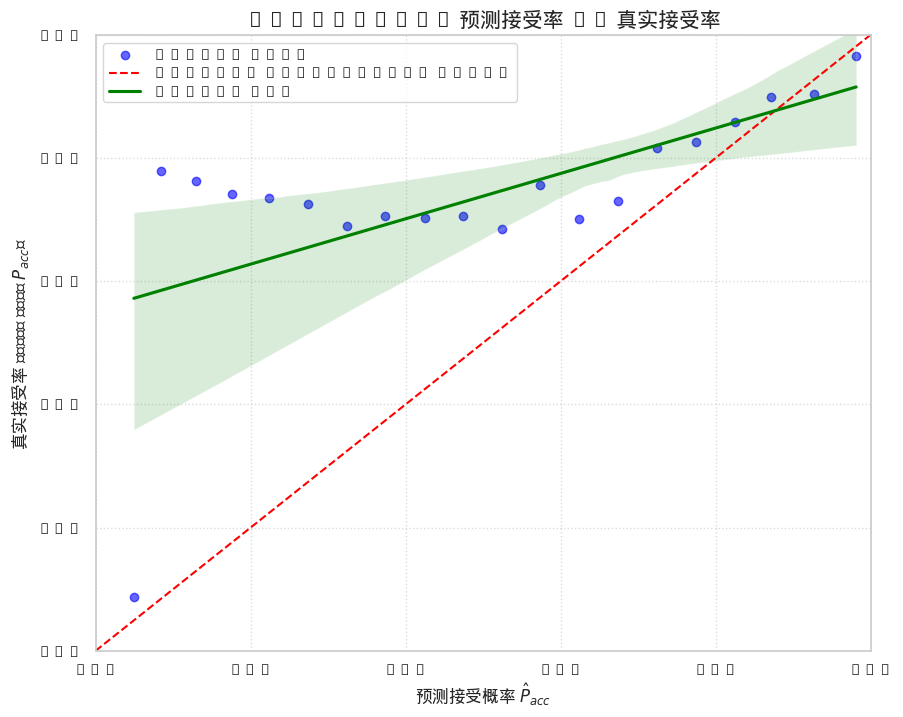

In [9]:
# 分箱处理 (Binning)
num_bins = 20
results_df['bin'] = pd.cut(results_df['predicted'], bins=np.linspace(0, 1, num_bins + 1))

# 计算每个 Bin 的平均预测值和平均真实接受率
bin_stats = results_df.groupby('bin', observed=True).agg({
    'predicted': 'mean',
    'real': 'mean'
}).dropna()

# 绘图
plt.figure(figsize=(10, 8))

# 绘制散点图
plt.scatter(bin_stats['predicted'], bin_stats['real'], color='blue', alpha=0.6, label='Binned Data')

# 绘制 y = x 参考线
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Perfect Calibration (y=x)')

# 绘制回归拟合线
if len(bin_stats) > 1:
    sns.regplot(data=bin_stats, x='predicted', y='real', scatter=False, color='green', label='Linear Fit')

plt.title('SpecDec++: 预测接受率 vs 真实接受率', fontsize=15)
plt.xlabel('预测接受概率 $\hat{P}_{acc}$', fontsize=12)
plt.ylabel('真实接受率 (Mean Real $P_{acc}$)', fontsize=12)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)

plt.show()


## 5. 误差分析与统计指标
计算相关的统计指标，如皮尔逊相关系数 (Pearson Correlation) 和均方误差 (MSE)，以量化模型的预测能力。

统计指标分析:
- 皮尔逊相关系数 (Pearson Correlation): 0.1226
- P-value: 4.6454e-23
- 均方误差 (MSE): 0.288538


/home/tiantianyi/code/DuoDecoding/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 108 (l) missing from font(s) Droid Sans Fallback.
  fig.canvas.print_figure(bytes_io, **kw)
/home/tiantianyi/code/DuoDecoding/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 112 (p) missing from font(s) Droid Sans Fallback.
  fig.canvas.print_figure(bytes_io, **kw)
/home/tiantianyi/code/DuoDecoding/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 45 (-) missing from font(s) Droid Sans Fallback.
  fig.canvas.print_figure(bytes_io, **kw)
/home/tiantianyi/code/DuoDecoding/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 49 (1) missing from font(s) Droid Sans Fallback.
  fig.canvas.print_figure(bytes_io, **kw)
/home/tiantianyi/code/DuoDecoding/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 46 (.) missing from font(s) Droid 

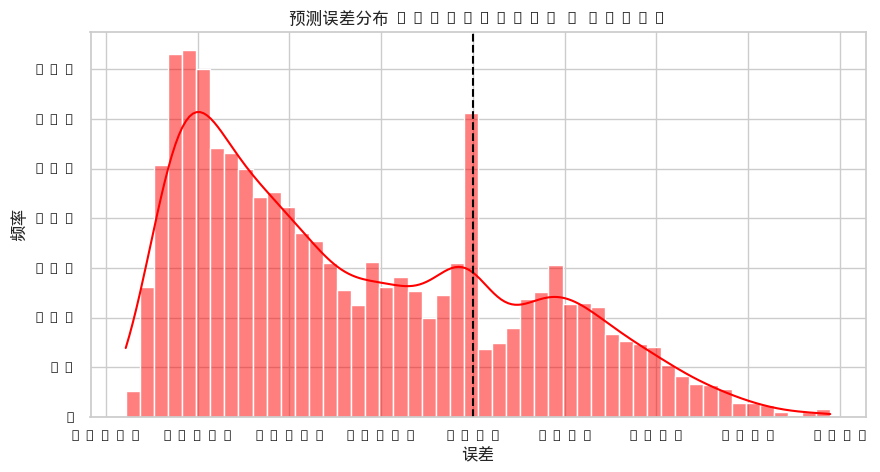

In [10]:
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

# 计算皮尔逊相关系数
corr, p_value = pearsonr(results_df['predicted'], results_df['real'])

# 计算均方误差 (MSE)
mse = mean_squared_error(results_df['real'], results_df['predicted'])

print(f"统计指标分析:")
print(f"- 皮尔逊相关系数 (Pearson Correlation): {corr:.4f}")
print(f"- P-value: {p_value:.4e}")
print(f"- 均方误差 (MSE): {mse:.6f}")

# 绘制误差分布图
plt.figure(figsize=(10, 5))
errors = results_df['predicted'] - results_df['real']
sns.histplot(errors, bins=50, kde=True, color='red')
plt.title('预测误差分布 (Predicted - Real)')
plt.xlabel('误差')
plt.ylabel('频率')
plt.axvline(0, color='black', linestyle='--')
plt.show()
